In [1]:
#Facebook's Prophet library already included in Colab
#!pip install fbprophet
#Install World Weather Online library and import other dependencies:
#!pip install wwo-hist
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from datetime import datetime, timedelta
import requests
from wwo_hist import retrieve_hist_data
from datetime import date
import pytz
%matplotlib inline

In [2]:
#Import our visit data from an excel file on Dropbox
df = pd.read_excel('daily-visits-incl-20-01-11.xlsx')
#Prophet only accepts these columns names:
df.columns = ['ds','y']
#Some of the timestamp day occasionally is off by a few milliseconds, not sure why, but we'll fix it by rounding:
df['ds'] = df['ds'].dt.round('15min')
#I've saved the data as hourly visits, so to convert to daily visits we group by date:
df = df.groupby([df['ds'].dt.date]).sum()
df = df.reset_index()
df = df.dropna()
df.tail()

,ds,y
2806,2020-01-07,314
2807,2020-01-08,259
2808,2020-01-09,241
2809,2020-01-10,239
2810,2020-01-11,171


In [3]:
#Import our stat days excel file, split them by RAMQ vs JGH
stat_days_df = pd.read_excel('https://www.dropbox.com/s/6kv67yhuv6f3b3h/statdays.xlsx?dl=1')
print(stat_days_df.head())
ramq_stat_days = stat_days_df['RAMQ']
ramq_stat_days = ramq_stat_days.dropna()
print(ramq_stat_days.head())
jgh_stat_days = stat_days_df['JGH']
jgh_stat_days = jgh_stat_days.dropna()
print(jgh_stat_days.head())

        RAMQ        JGH
0 2015-05-18 2015-05-18
1 2015-06-24 2015-06-24
2 2015-07-01 2015-07-01
3 2015-09-07 2015-09-07
4 2015-10-12 2015-10-12
0   2015-05-18
1   2015-06-24
2   2015-07-01
3   2015-09-07
4   2015-10-12
Name: RAMQ, dtype: datetime64[ns]
0   2015-05-18
1   2015-06-24
2   2015-07-01
3   2015-09-07
4   2015-10-12
Name: JGH, dtype: datetime64[ns]


In [4]:
#Save the stat day data in the format expected by Prophet
ramq_stat_days = pd.DataFrame({
  'holiday': 'ramq',
  'ds': ramq_stat_days.to_list(),
  'lower_window': 0,
  'upper_window': 1,
})
print(ramq_stat_days.head())
jgh_stat_days = pd.DataFrame({
  'holiday': 'jgh',
  'ds': jgh_stat_days.to_list(),
  'lower_window': 0,
  'upper_window': 1,
})
print(jgh_stat_days.head())
holidays = pd.concat((ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

  holiday         ds  lower_window  upper_window
0    ramq 2015-05-18             0             1
1    ramq 2015-06-24             0             1
2    ramq 2015-07-01             0             1
3    ramq 2015-09-07             0             1
4    ramq 2015-10-12             0             1
  holiday         ds  lower_window  upper_window
0     jgh 2015-05-18             0             1
1     jgh 2015-06-24             0             1
2     jgh 2015-07-01             0             1
3     jgh 2015-09-07             0             1
4     jgh 2015-10-12             0             1
   holiday         ds  lower_window  upper_window
44     jgh 2018-08-06             0             1
25    ramq 2017-04-17             0             1
29    ramq 2017-09-04             0             1
39    ramq 2018-05-21             0             1
32     jgh 2017-12-25             0             1
52    ramq 2019-05-20             0             1
59    ramq 2019-12-26             0             1
69    ramq 2

In [5]:
#Get all Montreal Canadiens games in our time frame (2012-present) from the NHL's REST API
resp = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId=8&startDate=2012-05-01&endDate=2020-05-01')
if resp.status_code != 200:
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

games = []
for date in resp.json()['dates']:
  for g in date['games']:
    for hour in [0,1,2,3]:
          toAppend = {'dateTime':datetime.strptime(g['gameDate'], "%Y-%m-%dT%H:%M:%SZ")-timedelta(hours=5-hour),'homeTeam':g['teams']['home']['team']['name'], 'awayTeam':g['teams']['away']['team']['name']}
          toAppend['awayScore'] = g['teams']['away']['score']
          toAppend['homeScore'] = g['teams']['home']['score']
          games.append(toAppend)
hockey_df = pd.DataFrame(games)
hockey_df['dateTime'] = hockey_df['dateTime'].dt.date
print(hockey_df.sample(5))

#Separate the games by Home or Away
home_hockey_df = hockey_df[hockey_df['homeTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(home_hockey_df.sample(5))

away_hockey_df = hockey_df[hockey_df['awayTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(away_hockey_df.sample(5))

#Format them as Prophet expects
home_hockey = pd.DataFrame({
  'holiday': 'homeHockey',
  'ds': pd.to_datetime(home_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

away_hockey = pd.DataFrame({
  'holiday': 'awayHockey',
  'ds': pd.to_datetime(away_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

#Add the hockey games to our stat day data
holidays = pd.concat((home_hockey, away_hockey, ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

        dateTime            homeTeam            awayTeam  awayScore  homeScore
2415  2019-02-25   New Jersey Devils  Montréal Canadiens          1          2
654   2014-10-01  Chicago Blackhawks  Montréal Canadiens          3          1
294   2013-11-01      Minnesota Wild  Montréal Canadiens          3          4
2314  2018-12-28    Florida Panthers  Montréal Canadiens          5          3
1346  2016-03-15  Montréal Canadiens    Florida Panthers          4          1
        dateTime            homeTeam            awayTeam  awayScore  homeScore
1550  2016-12-20  Montréal Canadiens       Anaheim Ducks          1          5
1438  2016-10-20  Montréal Canadiens     Arizona Coyotes          2          5
208   2013-05-09  Montréal Canadiens     Ottawa Senators          6          1
518   2014-03-18  Montréal Canadiens  Colorado Avalanche          3          6
471   2014-02-06  Montréal Canadiens   Vancouver Canucks          2          5
        dateTime             homeTeam            awa

In [6]:
#Load our weather data from Dropbox
weather_df = pd.read_csv('https://www.dropbox.com/s/p4g902q6hpgwju2/hist-hourly-weather-incl-19-12-13.csv?dl=1')
weather_df['date_time']=pd.to_datetime(weather_df['date_time'])
#The Moon and Sunrise/set data are not numerical, so we'll drop them for this analysis
weather_df = weather_df.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
weather_df = weather_df.rename(columns={"date_time": "ds"})
weather_df.tail()

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
2778,2019-12-09,3,-3,0.0,3.3,1,1,84,2,-2,...,-2,28,100,96,19.2,1011,3,8,159,16
2779,2019-12-10,7,-5,0.0,3.3,1,1,92,-2,-3,...,-3,35,72,75,4.6,1005,7,9,250,22
2780,2019-12-11,-2,-7,0.0,8.7,1,1,99,-14,-9,...,-9,20,43,48,1.1,1022,-2,8,182,15
2781,2019-12-12,-5,-12,0.0,8.7,1,1,100,-13,-12,...,-12,23,42,60,0.0,1034,-5,10,239,15
2782,2019-12-13,1,-4,0.0,8.7,1,1,87,-5,-5,...,-5,22,59,75,0.3,1026,1,9,169,13


In [7]:
#Fetch whichever days are missing, and 2 days into the future (weather forecast), which is the maximum the WWO API let's us access through the this API
#The Data is saved as a csv file called 'Montreal'
frequency = 24
start_date = (weather_df.ds.max()+timedelta(days=1)).date().strftime("%d-%b-%Y").upper()
end_date = (datetime.now(pytz.utc)+timedelta(days=2)).astimezone(pytz.timezone('US/Eastern')).date().strftime("%d-%b-%Y").upper()
api_key = '3d51d04f983a478e90f164916191012'
location_list = ['Montreal']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for Montreal


Currently retrieving data for Montreal: from 2019-12-14 to 2019-12-31
Time elapsed (hh:mm:ss.ms) 0:00:00.613082
Currently retrieving data for Montreal: from 2020-01-01 to 2020-01-14
Time elapsed (hh:mm:ss.ms) 0:00:01.045065


export Montreal completed!




In [8]:
#Load the missing weather data from the CSV file
missing_weather_df = pd.read_csv('Montreal.csv')
missing_weather_df['date_time']=pd.to_datetime(missing_weather_df['date_time'])
missing_weather_df = missing_weather_df.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
missing_weather_df = missing_weather_df.rename(columns={"date_time": "ds"})
missing_weather_df

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2019-12-14,4,1,0.0,3.3,1,1,79,2,-1,...,-1,26,97,97,27.1,1000,4,7,54,15
1,2019-12-15,0,-8,0.0,3.3,1,1,72,-16,-16,...,-16,35,0,53,0.0,1016,0,10,0,26
2,2019-12-16,-4,-9,0.0,8.7,1,1,65,-13,-12,...,-12,21,33,59,0.0,1022,-4,10,253,15
3,2019-12-17,-2,-5,2.4,3.3,1,1,58,-7,-6,...,-6,9,74,80,3.4,1013,-2,7,55,6
4,2019-12-18,-3,-13,2.0,3.3,1,1,50,-8,-10,...,-10,19,94,87,2.7,1007,-3,5,249,14
5,2019-12-19,-12,-16,0.0,3.3,1,1,43,-18,-24,...,-24,35,75,70,0.0,1023,-12,10,267,25
6,2019-12-20,-9,-15,0.0,8.7,1,1,36,-14,-17,...,-17,15,24,79,0.0,1036,-9,10,259,11
7,2019-12-21,-7,-11,0.0,3.3,1,1,28,-11,-12,...,-12,8,67,86,0.0,1034,-7,10,67,5
8,2019-12-22,2,-8,0.0,3.3,1,1,21,-3,-5,...,-5,19,98,90,0.0,1021,2,10,236,11
9,2019-12-23,5,1,0.0,3.3,1,1,14,0,-2,...,-2,30,81,86,0.0,1013,5,9,238,17


In [9]:
#Concatenate the old weather data with the missing weather data
final_weather_df = pd.concat([weather_df, missing_weather_df])
final_weather_df.tail(14)

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
18,2020-01-01,-1,-6,6.7,3.3,1,1,37,-3,-7,...,-7,25,80,91,5.8,1000,-1,6,265,15
19,2020-01-02,1,-4,0.3,3.3,1,1,44,-2,-5,...,-5,19,90,92,0.5,1007,1,9,189,11
20,2020-01-03,2,1,0.0,3.3,1,1,51,1,-1,...,-1,18,99,98,0.0,1006,2,2,231,10
21,2020-01-04,-2,-7,0.9,3.3,1,1,59,-4,-6,...,-6,13,84,91,1.6,1007,-2,7,34,8
22,2020-01-05,-6,-10,1.3,6.9,1,1,66,-8,-11,...,-11,15,49,87,1.1,1009,-6,9,289,10
23,2020-01-06,-2,-11,6.2,3.3,1,1,73,-8,-11,...,-11,12,95,94,7.5,1010,-2,6,159,8
24,2020-01-07,-6,-13,0.4,6.9,1,1,80,-8,-12,...,-12,19,62,87,1.2,1014,-6,9,214,11
25,2020-01-08,-1,-12,3.9,3.4,1,1,88,-6,-8,...,-8,25,88,88,5.1,1011,-1,5,269,16
26,2020-01-09,-13,-17,0.0,6.9,1,1,95,-16,-20,...,-20,17,44,87,0.0,1037,-13,10,204,11
27,2020-01-10,1,-9,0.2,3.4,1,1,100,-3,-6,...,-6,20,92,92,1.6,1025,1,4,185,12


In [10]:
#Make a list of our weather variables
regressors = final_weather_df.columns.to_list()
regressors.remove('ds')
print(regressors)
print(len(regressors))

['maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'uvIndex.1', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']
20


In [11]:
#Some final formatting our our data to be able to merge it with the weather data
df.ds = pd.to_datetime(df.ds)
final_df = pd.merge(df, final_weather_df, on='ds')
final_df.tail()

,ds,y,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
2806,2020-01-07,314,-6,-13,0.4,6.9,1,1,80,-8,...,-12,19,62,87,1.2,1014,-6,9,214,11
2807,2020-01-08,259,-1,-12,3.9,3.4,1,1,88,-6,...,-8,25,88,88,5.1,1011,-1,5,269,16
2808,2020-01-09,241,-13,-17,0.0,6.9,1,1,95,-16,...,-20,17,44,87,0.0,1037,-13,10,204,11
2809,2020-01-10,239,1,-9,0.2,3.4,1,1,100,-3,...,-6,20,92,92,1.6,1025,1,4,185,12
2810,2020-01-11,171,5,-4,10.0,3.4,1,1,100,2,...,-2,26,100,99,56.6,1015,5,5,142,15


In [12]:
#Instantiate our model with our stat day and hockey variables saved in the 'holidays' dataframe
m = Prophet(holidays=holidays)
#Add Prophet's built-in holidays for Canada
m.add_country_holidays(country_name='CA')
#Add our 20 weather variables as regressors
for regressor in regressors:
  m.add_regressor(regressor)
#Fit our model to our data
m.fit(final_df)
#Fit our model to data from before 2019
#m.fit(final_df[final_df.ds<'2019-01-01'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/prophet/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [13]:
forecast = m.predict(final_weather_df)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower  yhat_upper
2810 2020-01-10  272.578058  251.249781  292.612985
2811 2020-01-11  215.329143  194.175182  236.833881
2812 2020-01-12  156.001755  135.027792  176.045881
2813 2020-01-13  288.518507  267.546149  308.732961
2814 2020-01-14  262.179196  243.817902  282.304855


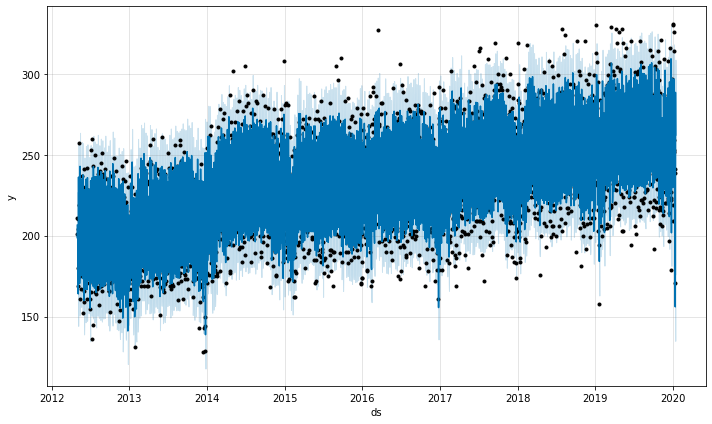

In [14]:
fig1 = m.plot(forecast)

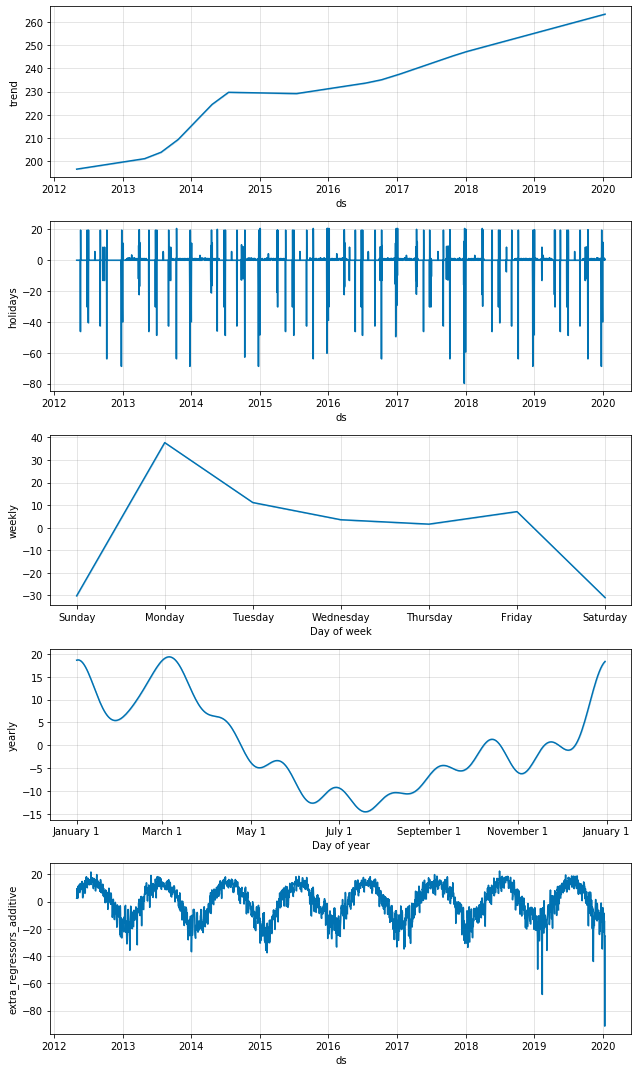

In [15]:
fig2 = m.plot_components(forecast)

In [16]:
import pickle
pkl_path = "jgh-prophet-20-01-12.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

In [17]:
# read the Prophet model object
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

In [18]:
m